In [1]:
#Check if dataset loads
import csv
import os
import numpy as np
import cv2
import keras

dataset_path = "../../data/speed_challenge_2017/data/train_seq/"
output_path = "../../data/speed_challenge_2017/data/train.txt"

image_paths = sorted(os.listdir(dataset_path))

with open(output_path, 'r') as h:
    lines = h.readlines()

dataset = []
for i in range(len(image_paths)):
    speed_val = float(lines[i].strip())
    dataset.append({"image": image_paths[i], "speed": speed_val/15.0 - 1.0})

print(len(dataset))

# dataset = [dataset[i] for i in range(len(dataset)) if i%2 == 0]

# print(len(dataset))

Using TensorFlow backend.


20400


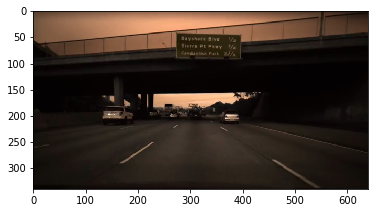

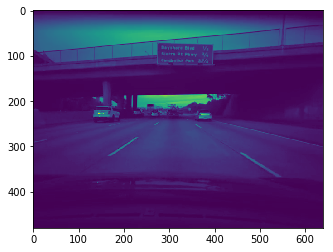

(480, 640)


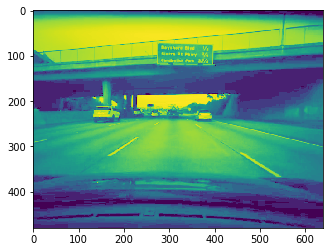

In [2]:
#ToDO
# Better training of RNN by reducing the frequency
# Input type, maybe saturation
# Providing additional features

# Sample processing
import matplotlib.pyplot as plt

img = cv2.imread(dataset_path + dataset[5]['image'])[30:370, :]
plt.imshow(img)
plt.show()

img_b = cv2.imread(dataset_path + dataset[5]['image'], 0)
plt.imshow(img_b)
plt.show()

# sat = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)[:, :, 1]
# plt.imshow(sat)
# plt.show()

# Equalize hist
equ = cv2.equalizeHist(img_b)
print(equ.shape)
#res = np.hstack((img_b, sat, equ))
plt.imshow(equ)
plt.show()

# for i in range(len(dataset)):
#     img = cv2.imread(dataset[i]['image'])[30:340, :, :]
#     img_b = cv2.imread(dataset[i]['image'], 0)[30:340, :]
#     sat = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)[:, :, 2]
#     equ = cv2.equalizeHist(img_b)
#     res = np.vstack((np.hstack((img_b, equ)), np.hstack((img_b, sat))))
#     cv2.imshow("view", res)
#     if chr(cv2.waitKey(0)) == 'q':
#         break

# cv2.destroyAllWindows()

In [3]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

cols = 640
rows = 340

seq_len = 20
BATCH_SIZE = 10

train_set, valid_set = train_test_split(dataset, test_size=0.10)

print("train set has {} elements".format(len(train_set)))
print("valid set has {} elements".format(len(valid_set)))

def data_generator(path, dataset, seq_len):
    batch_seq_images = np.zeros((BATCH_SIZE, seq_len, rows, cols, 1))
    batch_seq_speed = np.zeros((BATCH_SIZE, seq_len, 1))

    while 1:
        for i in range(BATCH_SIZE):
            while 1:
                index = np.random.randint(len(dataset))
                if index + seq_len <= len(dataset):
                    seq_speed = []
                    seq_images = []
                    for j in range(index, index + seq_len):
                        seq_speed.append(dataset[j]["speed"])
                        img = cv2.imread(dataset_path + dataset[j]["image"], 0)[30:370, :]
                        img = cv2.equalizeHist(img)
                        img = np.asarray(img).reshape(rows, cols, 1)
                        seq_images.append(img)
                    seq_speed = np.array(seq_speed)
                    seq_images = np.array(seq_images)
                    break
                else:
                    continue
            batch_seq_images[i] = seq_images
            batch_seq_speed[i] = seq_speed.reshape(seq_len, 1)

        # for ru
        yield batch_seq_images, batch_seq_speed[:, -1, :]

train set has 18360 elements
valid set has 2040 elements


In [ ]:
sample_gen = data_generator(dataset_path, train_set, seq_len)
x, y = next(sample_gen)
print(y)

In [4]:
from keras.models import Sequential, Model
from keras.layers.core import Lambda, Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Cropping2D, Convolution2D, MaxPooling2D, AveragePooling2D
from keras.layers.advanced_activations import ELU
from keras.layers.recurrent import GRU, LSTM
from keras.layers.normalization import BatchNormalization
from keras.layers.wrappers import TimeDistributed
from keras.optimizers import Adam, RMSprop

print("\nBuilding and compiling the model ...")

model = Sequential()
# Preprocess incoming data, centered around zero with small standard deviation 
model.add(TimeDistributed(Lambda(lambda x: (x / 127.5) - 1.0), input_shape=(None, rows, cols, 1)))
# Block - conv
model.add(TimeDistributed(Convolution2D(1, 11, 11, border_mode='valid', subsample=[3, 3], init='glorot_uniform', name='Conv1')))
model.add(TimeDistributed(BatchNormalization(axis=1)))
model.add(Activation('relu'))
# Block - conv
model.add(TimeDistributed(Convolution2D(1, 5, 5, border_mode='valid', init='glorot_uniform', name='Conv2')))
#model.add(TimeDistributed(BatchNormalization(axis=1)))
model.add(Activation('relu'))
# Block - conv
model.add(TimeDistributed(Convolution2D(1, 3, 3, border_mode='valid', init='glorot_uniform', name='Conv3')))  
#model.add(TimeDistributed(BatchNormalization(axis=1)))
model.add(Activation('relu'))
# Block - conv
model.add(TimeDistributed(Convolution2D(1, 3, 3, border_mode='valid', init='glorot_uniform', name='Conv4')))
#model.add(TimeDistributed(BatchNormalization(axis=1)))
model.add(Activation('relu'))
#Block - conv
model.add(TimeDistributed(Convolution2D(1, 3, 3, border_mode='valid', init='glorot_uniform', name='Conv5')))
#model.add(TimeDistributed(BatchNormalization(axis=1)))
model.add(Activation('relu'))
#model.add(TimeDistributed(MaxPooling2D((3,3),(2,2),'valid', name='pool3')))

#model.add(TimeDistributed(AveragePooling2D((4,4),(4,4),'valid', name='pool1')))
model.add(TimeDistributed(Flatten(name='flat')))
#model.add(Activation('relu'))
#model.add(TimeDistributed(Dropout(0.50)))
model.add(TimeDistributed(Dense(256, init='glorot_uniform', name='fc1')))
model.add(Activation('relu'))
model.add(LSTM(16, return_sequences=False, init='glorot_uniform', inner_init='glorot_uniform', activation='relu',
             name='GRU1'))
#model.add(Dropout(0.50))
model.add(Dense(1, name='output')) 
model.summary()

adam = Adam()
#rmsprop = RMSprop()
model.compile(loss='mean_squared_error', optimizer=adam)


Building and compiling the model ...
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
timedistributed_1 (TimeDistribut (None, None, 340, 640 0           timedistributed_input_1[0][0]    
____________________________________________________________________________________________________
timedistributed_2 (TimeDistribut (None, None, 110, 210 122         timedistributed_1[0][0]          
____________________________________________________________________________________________________
timedistributed_3 (TimeDistribut (None, None, 110, 210 440         timedistributed_2[0][0]          
____________________________________________________________________________________________________
activation_1 (Activation)        (None, None, 110, 210 0           timedistributed_3[0][0]          
_____________________________________________________

In [ ]:
import keras
from keras.callbacks import Callback
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
import math

class LifeCycleCallBack(keras.callbacks.Callback):
    
    def on_epoch_begin(self, epoch, logs={}):
        pass
    
    def on_epoch_end(self, epoch, logs={}):
        pass

    def on_batch_begin(self, batch, logs={}):
        pass
    
    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        
    def on_train_begin(self, logs={}):
        print('Beginning training')
        self.losses = []
        
    def on_train_end(self, logs={}):
        print('Ending Training')


NUM_EPOCHS = 250
        
lifecycle_callback = LifeCycleCallBack()

tensorboard = keras.callbacks.TensorBoard(log_dir='../../data/logs/speed_challenge/', histogram_freq=1, 
                                          write_graph=True, write_images=True)

checkpoint = keras.callbacks.ModelCheckpoint("../../data/weights/speed_challenge/model.h5", monitor='val_loss', verbose=0, 
                                             save_best_only=True, save_weights_only=True, mode='auto', period=1)

train_generator = data_generator(dataset_path, train_set, seq_len)
valid_generator = data_generator(dataset_path, valid_set, seq_len)

samples_per_epoch = math.ceil((len(train_set) - seq_len)/(seq_len*BATCH_SIZE))*BATCH_SIZE
nb_val_samples = math.ceil((len(valid_set) - seq_len)/(seq_len*BATCH_SIZE))*BATCH_SIZE

print("\nSaving Model...")

model_json = model.to_json()
with open("../../data/weights/speed_challenge/model.json", "w") as json_file:
    json_file.write(model_json)

#model.save_weights("model.h5")
print("Model Saved.")


history = model.fit_generator(train_generator,
                              validation_data=valid_generator,
                              samples_per_epoch=samples_per_epoch,
                              nb_val_samples=nb_val_samples,
                              nb_epoch=NUM_EPOCHS, verbose=1, 
                              callbacks=[lifecycle_callback, checkpoint])

print("\nTraining the model ended.")


Saving Model...
Model Saved.
Beginning training
Epoch 1/250
920/920 [==============================] - 100s - loss: 0.1807 - val_loss: 0.1235
Epoch 2/250
920/920 [==============================] - 91s - loss: 0.0644 - val_loss: 0.1224
Epoch 3/250
920/920 [==============================] - 91s - loss: 0.0429 - val_loss: 0.1154
Epoch 4/250
920/920 [==============================] - 91s - loss: 0.0372 - val_loss: 0.0920
Epoch 5/250
920/920 [==============================] - 91s - loss: 0.0304 - val_loss: 0.0864
Epoch 6/250
920/920 [==============================] - 91s - loss: 0.0312 - val_loss: 0.0537
Epoch 7/250
920/920 [==============================] - 91s - loss: 0.0223 - val_loss: 0.0578
Epoch 8/250
920/920 [==============================] - 91s - loss: 0.0182 - val_loss: 0.0565
Epoch 9/250
920/920 [==============================] - 91s - loss: 0.0234 - val_loss: 0.0391
Epoch 10/250
920/920 [==============================] - 91s - loss: 0.0216 - val_loss: 0.0473
Epoch 11/250
920/92